<a href="https://colab.research.google.com/github/christinaxliu/research/blob/main/CSRSEF/RandomForest_XGBoost_Classifiers_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap

In [ ]:
import warnings
import os
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from collections import Counter
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from IPython.display import Image
from six import StringIO
import pickle
import shap
from google.colab import drive

In [ ]:
warnings.simplefilter('ignore')
shap.initjs()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Feature names
feature_columns = [
    'sy_pnum: Number of Planets in the Planetary System',
    'pl_orbsmax: Planet Orbit Semi-Major Axis [au]',
    'pl_rade: Planet Radius [Earth Radius]',
    'pl_bmasse: Planet Mass or Mass*sin(i) [Earth Mass]',
    'pl_bmassprov: Planet Mass or Mass*sin(i) Provenance',
    'pl_orbeccen: Planet Orbit Eccentricity',
    'st_teff: Stellar Effective Temperature [K]',
    'st_rad: Stellar Radius [Solar Radius]',
    'st_mass: Stellar Mass [Solar mass]',
    'st_met: Stellar Metallicity [dex]',
    'st_metratio: Stellar Metallicity Ratio',
    'st_logg: Stellar Surface Gravity [log10(cm/s^2)]',
    'ra: Right Ascension of the Planetary System [decimal]',
    'dec: Declination of the Planetary System [decimal]',
    'sy_dist: Distance to the Planetary System [pc]',
    'sy_vmag: Stellar V (Johnson) Magnitude',
    'sy_kmag: Stellar Ks (2MASS) Magnitude'
]

In [ ]:
nasa_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/CSRSEF/bak_NASA_PSCompPars_2025.01.28.csv'
nasa_exoplanets_data = pd.read_table(nasa_exoplanets_filename,
                                      skiprows=89,
                                      sep=',',
                                      header=None,
                                      index_col=None,
                                      names = ['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag',
                                                'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                                'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                                'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                                'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                                'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                                'ttv_flag', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim',
                                                'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim',
                                                'st_metratio', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim', 'rastr', 'ra', 'decstr', 'dec',
                                                'sy_dist', 'sy_disterr1', 'sy_disterr2', 'sy_vmag', 'sy_vmagerr1', 'sy_vmagerr2', 'sy_kmag', 'sy_kmagerr1', 'sy_kmagerr2',
                                                'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2'],
                                      skipfooter=0,
                                      engine='python')

In [ ]:
# Sanity check the first several rows of data to ensure data is read correctly
nasa_exoplanets_data.head()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
0,11 Com b,11 Com,2,1,Radial Velocity,2007,Xinglong Station,0,323.21000,0.06000,...,-1.9238,4.72307,0.023,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848
1,11 UMi b,11 UMi,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,0,516.21997,3.20000,...,-1.9765,5.01300,0.005,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903
2,14 And b,14 And,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,0,186.76000,0.11000,...,-0.7140,5.23133,0.023,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826
3,14 Her b,14 Her,1,2,Radial Velocity,2002,W. M. Keck Observatory,0,1765.03890,1.67709,...,-0.0073,6.61935,0.023,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351
4,16 Cyg B b,16 Cyg B,3,1,Radial Velocity,1996,Multiple Observatories,0,798.50000,1.00000,...,-0.0111,6.21500,0.016,-0.016,4.651,0.016,-0.016,6.06428,0.000603,-0.000603


In [ ]:
# Sanity check the last several rows of data to ensure data is read correctly.
nasa_exoplanets_data.tail()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_controv_flag,pl_orbper,pl_orbpererr1,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
5829,ups And b,ups And,2,3,Radial Velocity,1996,Lick Observatory,0,4.617033,0.000023,...,-0.06290,4.09565,0.023,-0.023,2.859,0.274,-0.274,3.98687,0.008937,-0.008937
5830,ups And c,ups And,2,3,Radial Velocity,1999,Multiple Observatories,0,241.258000,0.064000,...,-0.06290,4.09565,0.023,-0.023,2.859,0.274,-0.274,3.98687,0.008937,-0.008937
5831,ups And d,ups And,2,3,Radial Velocity,1999,Multiple Observatories,0,1276.460000,0.570000,...,-0.06290,4.09565,0.023,-0.023,2.859,0.274,-0.274,3.98687,0.008937,-0.008937
5832,ups Leo b,ups Leo,1,1,Radial Velocity,2021,Okayama Astrophysical Observatory,0,385.200000,2.800000,...,-0.89630,4.30490,0.023,-0.023,2.184,0.248,-0.248,4.03040,0.008513,-0.008513
5833,xi Aql b,xi Aql,1,1,Radial Velocity,2007,Okayama Astrophysical Observatory,0,136.970000,0.110000,...,-0.55975,4.70964,0.023,-0.023,2.171,0.220,-0.220,4.42501,0.003837,-0.003837


In [ ]:
# Get the statistics about the data
nasa_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5834 entries, 0 to 5833
Data columns (total 84 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          5834 non-null   object 
 1   hostname         5834 non-null   object 
 2   sy_snum          5834 non-null   int64  
 3   sy_pnum          5834 non-null   int64  
 4   discoverymethod  5834 non-null   object 
 5   disc_year        5834 non-null   int64  
 6   disc_facility    5834 non-null   object 
 7   pl_controv_flag  5834 non-null   int64  
 8   pl_orbper        5548 non-null   float64
 9   pl_orbpererr1    5051 non-null   float64
 10  pl_orbpererr2    5051 non-null   float64
 11  pl_orbperlim     5548 non-null   float64
 12  pl_orbsmax       5550 non-null   float64
 13  pl_orbsmaxerr1   3607 non-null   float64
 14  pl_orbsmaxerr2   3607 non-null   float64
 15  pl_orbsmaxlim    5551 non-null   float64
 16  pl_rade          5813 non-null   float64
 17  pl_radeerr1   

In [ ]:
# Only selects exoplanets with pl_controv_flag == 0
nasa_exoplanets_data = nasa_exoplanets_data.loc[(nasa_exoplanets_data['pl_controv_flag'] == 0)]

In [ ]:
nasa_exoplanets_data = nasa_exoplanets_data.loc[
    (~np.isnan(nasa_exoplanets_data['sy_snum'])) & (nasa_exoplanets_data['sy_snum'] == 1)
    & ~np.isnan(nasa_exoplanets_data['st_teff'])
    & ~np.isnan(nasa_exoplanets_data['st_rad'])
    & ~np.isnan(nasa_exoplanets_data['pl_orbsmax'])]

In [ ]:
hwc_exoplanets_filename = '/content/drive/My Drive/Colab Notebooks/research/CSRSEF/hwc_2025.01.28.csv'
hwc_exoplanets_data = pd.read_csv(hwc_exoplanets_filename)
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


In [ ]:
hwc_exoplanets_data = hwc_exoplanets_data.loc[~np.isnan(hwc_exoplanets_data['P_HABITABLE'])]
hwc_exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.1+ MB


In [ ]:
exoplanets_data = pd.merge(nasa_exoplanets_data,
                           hwc_exoplanets_data[['P_HABITABLE']],
                           how="left",
                           left_on=nasa_exoplanets_data['pl_name'].str.lower(),
                           right_on=hwc_exoplanets_data['P_NAME'].str.lower())
exoplanets_data = exoplanets_data.drop(['key_0'], axis = 1)

# Change any fields with empty spaces to NaN values so we can clean them up
exoplanets_data = exoplanets_data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
exoplanets_data = exoplanets_data.loc[~np.isnan(exoplanets_data['P_HABITABLE'])]

exoplanets_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4582 entries, 0 to 4768
Data columns (total 85 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          4582 non-null   object 
 1   hostname         4582 non-null   object 
 2   sy_snum          4582 non-null   int64  
 3   sy_pnum          4582 non-null   int64  
 4   discoverymethod  4582 non-null   object 
 5   disc_year        4582 non-null   int64  
 6   disc_facility    4582 non-null   object 
 7   pl_controv_flag  4582 non-null   int64  
 8   pl_orbper        4545 non-null   float64
 9   pl_orbpererr1    4084 non-null   float64
 10  pl_orbpererr2    4084 non-null   float64
 11  pl_orbperlim     4545 non-null   float64
 12  pl_orbsmax       4582 non-null   float64
 13  pl_orbsmaxerr1   2725 non-null   float64
 14  pl_orbsmaxerr2   2725 non-null   float64
 15  pl_orbsmaxlim    4582 non-null   float64
 16  pl_rade          4573 non-null   float64
 17  pl_radeerr1      33

In [ ]:
exoplanets_data.to_csv('/content/drive/My Drive/Colab Notebooks/research/CSRSEF/NasaJoinedWithHWCData_2025.01.28.csv')

In [ ]:
# Drop data fields that are not relevant to the training
training_prep_data = exoplanets_data.drop(['pl_name', 'hostname', 'sy_snum',
                                            'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag',
                                            'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim',
                                            'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbperlim',
                                            'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
                                            'pl_radeerr1', 'pl_radeerr2', 'pl_radelim',
                                            'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim',
                                            'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim',
                                            'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim',
                                            'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
                                            'pl_insolerr1', 'pl_insolerr2', 'pl_insollim',
                                            'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
                                            'ttv_flag', 'st_tefferr1', 'st_tefferr2', 'st_tefflim',
                                            'st_raderr1', 'st_raderr2', 'st_radlim',
                                            'st_masserr1', 'st_masserr2', 'st_masslim',
                                            'st_meterr1', 'st_meterr2', 'st_metlim',
                                            'st_loggerr1', 'st_loggerr2', 'st_logglim',
                                            'rastr', 'decstr',
                                            'sy_disterr1', 'sy_disterr2', 'sy_vmagerr1', 'sy_vmagerr2',
                                            'sy_kmagerr1', 'sy_kmagerr2', 'sy_gaiamagerr1', 'sy_gaiamagerr2'],
                                          axis = 1)

# Drop data fields that are duplicate to others
training_prep_data = training_prep_data.drop(['pl_bmassj', 'pl_radj'], axis = 1)

# Drop data fields that are too correlated to the label
training_prep_data = training_prep_data.drop(['pl_eqt'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4582 entries, 0 to 4768
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4582 non-null   int64  
 1   pl_orbper     4545 non-null   float64
 2   pl_orbsmax    4582 non-null   float64
 3   pl_rade       4573 non-null   float64
 4   pl_bmasse     4559 non-null   float64
 5   pl_bmassprov  4582 non-null   object 
 6   pl_orbeccen   4298 non-null   float64
 7   pl_insol      3571 non-null   float64
 8   st_spectype   1529 non-null   object 
 9   st_teff       4582 non-null   float64
 10  st_rad        4582 non-null   float64
 11  st_mass       4581 non-null   float64
 12  st_met        4435 non-null   float64
 13  st_metratio   4417 non-null   object 
 14  st_logg       4576 non-null   float64
 15  ra            4582 non-null   float64
 16  dec           4582 non-null   float64
 17  sy_dist       4567 non-null   float64
 18  sy_vmag       4575 non-null   flo

In [ ]:
training_prep_data['P_HABITABLE'].value_counts()

,count
P_HABITABLE,
0.0,4527
2.0,31
1.0,24


In [ ]:
training_prep_data['hz_label'] = training_prep_data['P_HABITABLE']
training_prep_data.loc[training_prep_data['hz_label'] == 2, 'hz_label'] = 1
training_prep_data['hz_label'].value_counts()

,count
hz_label,
0.0,4527
1.0,55


In [ ]:
training_prep_data = training_prep_data.drop(['P_HABITABLE'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4582 entries, 0 to 4768
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4582 non-null   int64  
 1   pl_orbper     4545 non-null   float64
 2   pl_orbsmax    4582 non-null   float64
 3   pl_rade       4573 non-null   float64
 4   pl_bmasse     4559 non-null   float64
 5   pl_bmassprov  4582 non-null   object 
 6   pl_orbeccen   4298 non-null   float64
 7   pl_insol      3571 non-null   float64
 8   st_spectype   1529 non-null   object 
 9   st_teff       4582 non-null   float64
 10  st_rad        4582 non-null   float64
 11  st_mass       4581 non-null   float64
 12  st_met        4435 non-null   float64
 13  st_metratio   4417 non-null   object 
 14  st_logg       4576 non-null   float64
 15  ra            4582 non-null   float64
 16  dec           4582 non-null   float64
 17  sy_dist       4567 non-null   float64
 18  sy_vmag       4575 non-null   flo

In [ ]:
# Calculate the missing value % for each data field, then sort data fields by the missing value percentages
missing_value_count = training_prep_data.isnull().sum().sort_values(ascending=False)
missing_value_percentage = ((training_prep_data.isnull().sum() / training_prep_data.isnull().count()) * 100).sort_values(ascending=False)
missing_value_percentage_data = pd.concat([missing_value_count, missing_value_percentage], axis = 1, keys = ['Count', '%'])
missing_value_percentage_data.head(50)

,Count,%
st_spectype,3053,66.630292
pl_insol,1011,22.064601
pl_orbeccen,284,6.198167
st_metratio,165,3.601048
st_met,147,3.208206
pl_orbper,37,0.807508
sy_gaiamag,33,0.720210
pl_bmasse,23,0.501964
sy_dist,15,0.327368
pl_rade,9,0.196421


In [ ]:
# Drop off data fields with missing value % >= 25%
training_prep_data = training_prep_data.drop(['st_spectype'], axis = 1)
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4582 entries, 0 to 4768
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4582 non-null   int64  
 1   pl_orbper     4545 non-null   float64
 2   pl_orbsmax    4582 non-null   float64
 3   pl_rade       4573 non-null   float64
 4   pl_bmasse     4559 non-null   float64
 5   pl_bmassprov  4582 non-null   object 
 6   pl_orbeccen   4298 non-null   float64
 7   pl_insol      3571 non-null   float64
 8   st_teff       4582 non-null   float64
 9   st_rad        4582 non-null   float64
 10  st_mass       4581 non-null   float64
 11  st_met        4435 non-null   float64
 12  st_metratio   4417 non-null   object 
 13  st_logg       4576 non-null   float64
 14  ra            4582 non-null   float64
 15  dec           4582 non-null   float64
 16  sy_dist       4567 non-null   float64
 17  sy_vmag       4575 non-null   float64
 18  sy_kmag       4577 non-null   flo

In [ ]:
training_prep_data.select_dtypes(include = ['object']).columns

Index(['pl_bmassprov', 'st_metratio'], dtype='object')

In [ ]:
# Calculate the missing value % for the categorial data field, then sort categorial data fields by the missing value percentages
categorial_data_fields = training_prep_data.select_dtypes(include = ['object'])
missing_value_count = categorial_data_fields.isnull().sum().sort_values(ascending=False)
missing_value_percentage = ((categorial_data_fields.isnull().sum() / categorial_data_fields.isnull().count()) * 100).sort_values(ascending=False)
missing_value_percentage_data = pd.concat([missing_value_count, missing_value_percentage], axis = 1, keys = ['Count', '%'])
missing_value_percentage_data.head(50)

,Count,%
st_metratio,165,3.601048
pl_bmassprov,0,0.000000


In [ ]:
# Fill in the missing values in categorical data fields with mode
training_prep_data['st_metratio'] = training_prep_data['st_metratio'].fillna(training_prep_data['st_metratio'].mode()[0])

In [ ]:
# Encode categorical data fields to numeric values with Label Encoder
encoders = {}
for column in training_prep_data.select_dtypes(include = ['object']).columns:
    encoders[column] = LabelEncoder()
    training_prep_data[column] = encoders[column].fit_transform(training_prep_data[column])
training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4582 entries, 0 to 4768
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4582 non-null   int64  
 1   pl_orbper     4545 non-null   float64
 2   pl_orbsmax    4582 non-null   float64
 3   pl_rade       4573 non-null   float64
 4   pl_bmasse     4559 non-null   float64
 5   pl_bmassprov  4582 non-null   int64  
 6   pl_orbeccen   4298 non-null   float64
 7   pl_insol      3571 non-null   float64
 8   st_teff       4582 non-null   float64
 9   st_rad        4582 non-null   float64
 10  st_mass       4581 non-null   float64
 11  st_met        4435 non-null   float64
 12  st_metratio   4582 non-null   int64  
 13  st_logg       4576 non-null   float64
 14  ra            4582 non-null   float64
 15  dec           4582 non-null   float64
 16  sy_dist       4567 non-null   float64
 17  sy_vmag       4575 non-null   float64
 18  sy_kmag       4577 non-null   flo

In [ ]:
training_prep_data['pl_bmassprov'].value_counts()

,count
pl_bmassprov,
0,2561
1,1324
3,684
2,13


In [ ]:
training_prep_data['st_metratio'].value_counts()

,count
st_metratio,
0,4141
1,441


In [ ]:
# Fill in the missing values for the numeric data fields with Multivariate Imputation by Chained Equation (MICE) imputation
# https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00313-w
imputed_training_prep_data = training_prep_data.copy(deep = True)
mice_imputer = IterativeImputer()
imputed_training_prep_data.iloc[:, :] = mice_imputer.fit_transform(training_prep_data)
imputed_training_prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4582 entries, 0 to 4768
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       4582 non-null   int64  
 1   pl_orbper     4582 non-null   float64
 2   pl_orbsmax    4582 non-null   float64
 3   pl_rade       4582 non-null   float64
 4   pl_bmasse     4582 non-null   float64
 5   pl_bmassprov  4582 non-null   int64  
 6   pl_orbeccen   4582 non-null   float64
 7   pl_insol      4582 non-null   float64
 8   st_teff       4582 non-null   float64
 9   st_rad        4582 non-null   float64
 10  st_mass       4582 non-null   float64
 11  st_met        4582 non-null   float64
 12  st_metratio   4582 non-null   int64  
 13  st_logg       4582 non-null   float64
 14  ra            4582 non-null   float64
 15  dec           4582 non-null   float64
 16  sy_dist       4582 non-null   float64
 17  sy_vmag       4582 non-null   float64
 18  sy_kmag       4582 non-null   flo

In [ ]:
habitability_status_counts = Counter(imputed_training_prep_data['hz_label'])
for habitability_status_label, habitability_status_count in habitability_status_counts.items():
    habitability_status_percentage = (habitability_status_count / len(imputed_training_prep_data['hz_label'])) * 100
    print('hz_label=%d, count=%d (%.3f%%)' % (habitability_status_label, habitability_status_count, habitability_status_percentage))

hz_label=0, count=4527 (98.800%)
hz_label=1, count=55 (1.200%)


In [ ]:
features_to_balance, labels_to_balance = imputed_training_prep_data.drop(['hz_label'], axis = 1), imputed_training_prep_data.hz_label

smoteenn = SMOTEENN(random_state=0)
balanced_features, balanced_labels = smoteenn.fit_resample(features_to_balance, labels_to_balance)

habitability_status_counts = Counter(balanced_labels)
for habitability_status_label, habitability_status_count in habitability_status_counts.items():
    habitability_status_percentage = (habitability_status_count / len(balanced_labels)) * 100
    print('hz_label=%d, count=%d (%.3f%%)' % (habitability_status_label, habitability_status_count, habitability_status_percentage))

hz_label=0, count=4354 (49.242%)
hz_label=1, count=4488 (50.758%)


In [ ]:
balanced_training_prep_data = balanced_features
balanced_training_prep_data['hz_label'] = balanced_labels
balanced_training_prep_data.shape

(8842, 21)

In [ ]:
features = balanced_training_prep_data.drop('hz_label', axis = 1)
labels = balanced_training_prep_data['hz_label']
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8842 entries, 0 to 8841
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sy_pnum       8842 non-null   int64  
 1   pl_orbper     8842 non-null   float64
 2   pl_orbsmax    8842 non-null   float64
 3   pl_rade       8842 non-null   float64
 4   pl_bmasse     8842 non-null   float64
 5   pl_bmassprov  8842 non-null   int64  
 6   pl_orbeccen   8842 non-null   float64
 7   pl_insol      8842 non-null   float64
 8   st_teff       8842 non-null   float64
 9   st_rad        8842 non-null   float64
 10  st_mass       8842 non-null   float64
 11  st_met        8842 non-null   float64
 12  st_metratio   8842 non-null   int64  
 13  st_logg       8842 non-null   float64
 14  ra            8842 non-null   float64
 15  dec           8842 non-null   float64
 16  sy_dist       8842 non-null   float64
 17  sy_vmag       8842 non-null   float64
 18  sy_kmag       8842 non-null 

<Axes: >

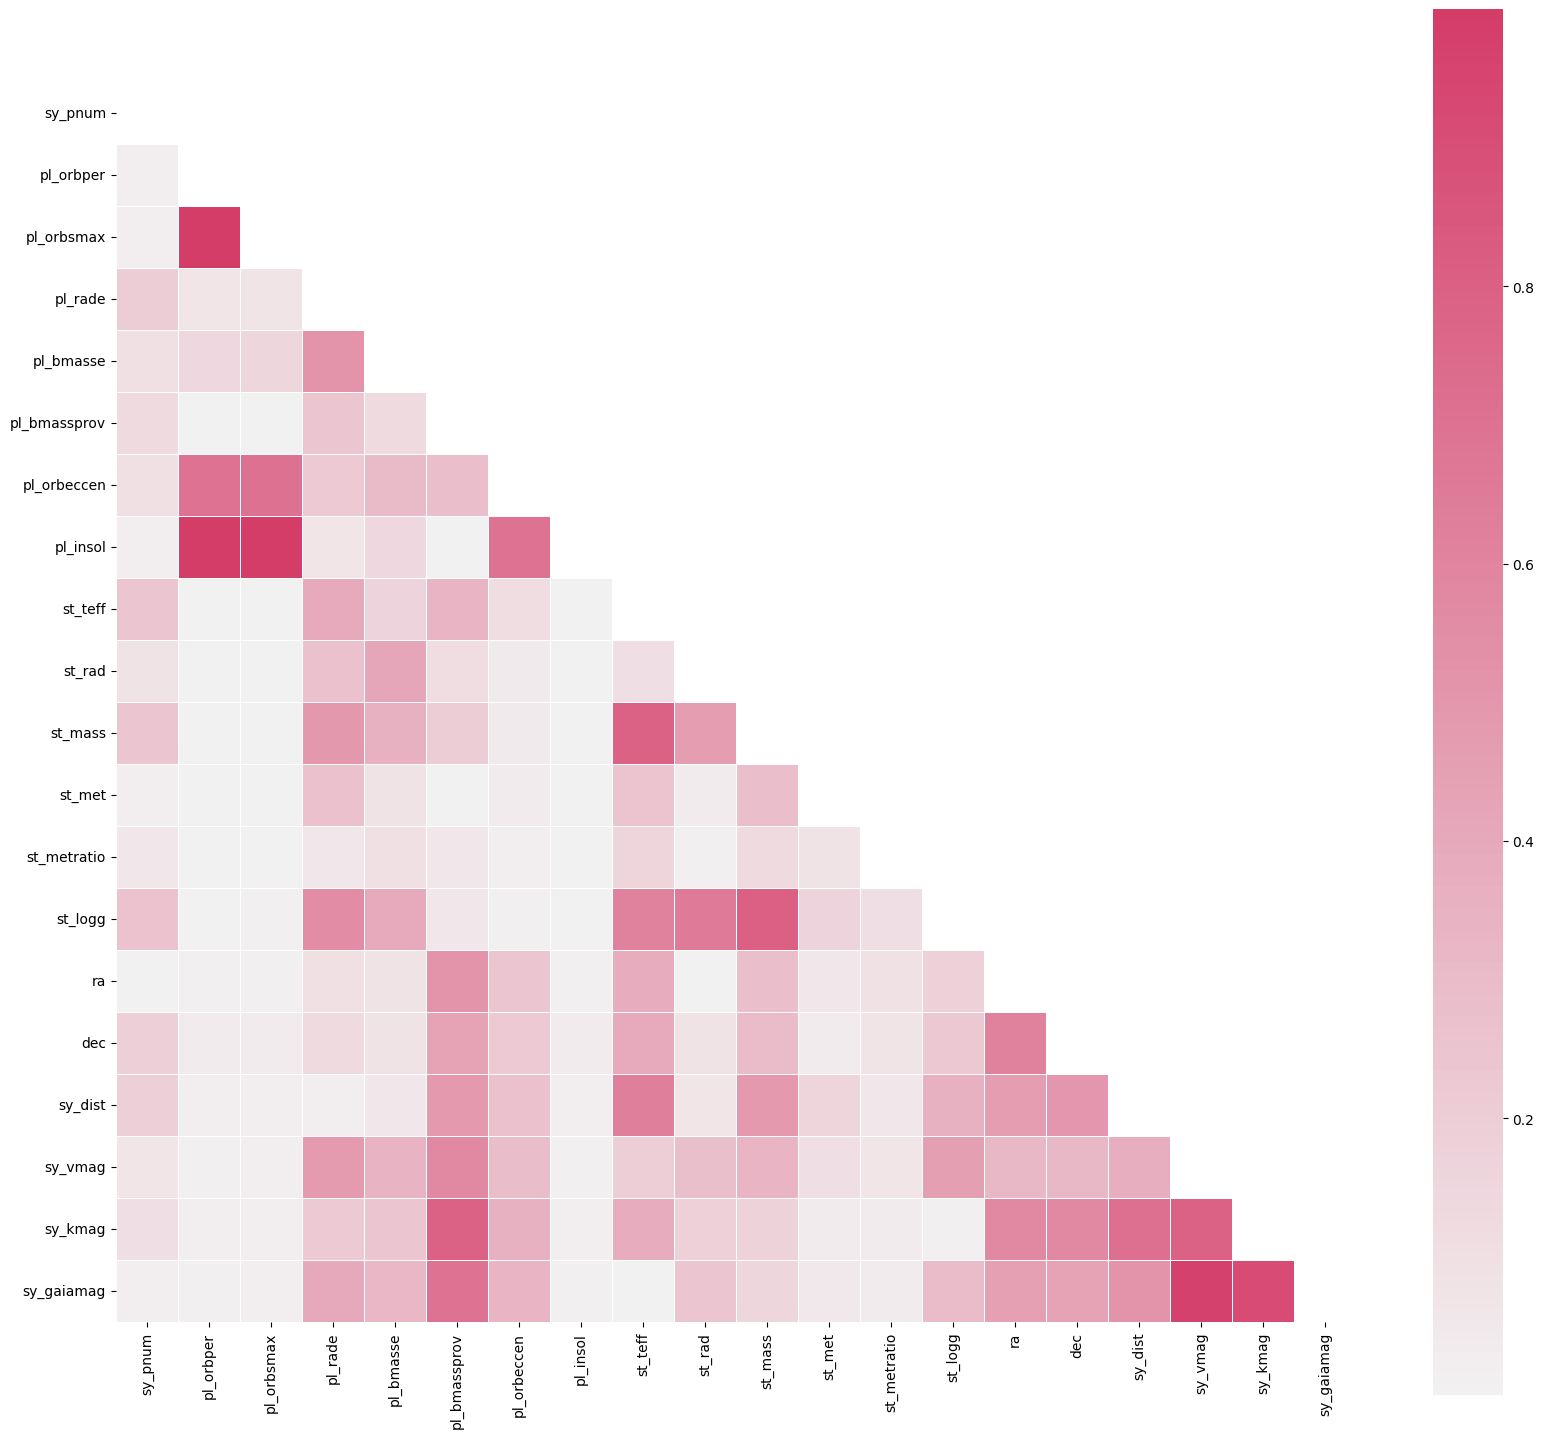

In [ ]:
correlation_matrix = features.corr().abs()

mask = np.triu(np.ones_like(correlation_matrix, dtype = np.bool_))
f, ax = plt.subplots(figsize = (20, 20))
cmap = sns.diverging_palette(255, 0, as_cmap = True)
sns.heatmap(correlation_matrix,
            mask = mask,
            cmap = cmap,
            vmax = None,
            center = 0,
            square = True,
            annot = False,
            linewidths = .5,
            cbar_kws = {"shrink": 0.9})

In [ ]:
# Drop highly correlated data fields
features = features.drop(['pl_orbper', 'pl_insol', 'sy_gaiamag'], axis = 1)

In [ ]:
# Split the preprocessed_training_data into train and test subsets
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.45,
                                                                            stratify=labels,
                                                                            random_state=42)

print(f"features_train dimensions: {features_train.shape}")
print(f"features_test dimensions: {features_test.shape}")
print(f"labels_train dimensions: {labels_train.shape}")
print(f"labels_test dimensions: {labels_test.shape}")

features_train dimensions: (4863, 17)
features_test dimensions: (3979, 17)
labels_train dimensions: (4863,)
labels_test dimensions: (3979,)


In [ ]:
minMaxScaler = MinMaxScaler()
features_train = minMaxScaler.fit_transform(features_train)
features_test = minMaxScaler.fit_transform(features_test)

In [ ]:
def plot_confusion_matrix(labels, predictions):
    # Create a confusion matrix that compares the prediction results against the labels
    confusionMatrix = confusion_matrix(labels, predictions)

    # Create a dataframe for the confusion matrix for plotting
    confusionMatrixDf = pd.DataFrame(confusionMatrix,
                                     index = ['Non-Habitable', 'Habitable'],
                                     columns = ['Non-Habitable', 'Habitable'])

    # Plot the confusion matrix
    plt.figure(figsize = (5,4))
    sns.heatmap(confusionMatrixDf, annot = True)
    plt.title('Habitability Confusion Matrix')
    plt.ylabel('Label Values')
    plt.xlabel('Predicted Values')
    plt.show()

    return confusionMatrix

In [ ]:
def search_optimal_params_random_forest(features,
                                        labels,
                                        cross_validation_rounds,
                                        split_test_size,
                                        split_stratify,
                                        split_random_state):
    print(f"Searching the optimal hyper parameters for Random Forest classifier...\n");
    minMaxScaler = MinMaxScaler()

    best_accuracy = 0
    best_n_estimators = 1
    best_criterion = 'gini'
    best_max_depth = 1
    best_max_features = 'log2'
    best_max_leaf_nodes = 1

    for n_estimators in range(1, 12, 1):
        for criterion in ['gini', 'entropy', 'log_loss']:
            for max_depth in range(1, 12, 1):
                for max_features in ['log2', 'sqrt']:
                    for max_leaf_nodes in range(2, 12, 1):
                        accuracy_sum = 0
                        for round in range(cross_validation_rounds):
                            features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                                        labels,
                                                                                                        test_size=split_test_size,
                                                                                                        stratify=split_stratify,
                                                                                                        random_state=split_random_state,
                                                                                                        shuffle=True)
                            features_train = minMaxScaler.fit_transform(features_train)
                            features_test = minMaxScaler.fit_transform(features_test)
                            random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                                                              criterion=criterion,
                                                                              max_depth=max_depth,
                                                                              max_features=max_features,
                                                                              max_leaf_nodes=max_leaf_nodes,
                                                                              random_state=0)
                            random_forest_classifier.fit(features_train, labels_train)

                            # Predict the samples in the test subset
                            random_forest_classifier_predictions = random_forest_classifier.predict(features_test)

                            # Plot the confusion matrix and print out the classification evaluation report
                            random_forest_classifier_accuracy = accuracy_score(labels_test, random_forest_classifier_predictions)
                            accuracy_sum += random_forest_classifier_accuracy
                        avg_accuracy = accuracy_sum / cross_validation_rounds
                        if avg_accuracy > best_accuracy:
                             best_accuracy = avg_accuracy
                             best_n_estimators = n_estimators
                             best_criterion = criterion,
                             best_max_depth = max_depth,
                             best_max_features = max_features,
                             best_max_leaf_nodes = max_leaf_nodes
                             print(f"Found a better avg accuracy at: {best_accuracy} - n_estimators: {best_n_estimators}, criterion: {best_criterion}, max_depth: {best_max_depth}, max_features: {best_max_features}, max_leaf_nodes: {best_max_leaf_nodes}")

search_optimal_params_random_forest(features=features,
                                    labels=labels,
                                    cross_validation_rounds=5,
                                    split_test_size=0.45,
                                    split_stratify=labels,
                                    split_random_state=42)

Searching the optimal hyper parameters for Random Forest classifier...

Found a better avg accuracy at: 0.8409148027142498 - n_estimators: 1, criterion: ('gini',), max_depth: (1,), max_features: ('log2',), max_leaf_nodes: 2
Found a better avg accuracy at: 0.8597637597386278 - n_estimators: 1, criterion: ('gini',), max_depth: (3,), max_features: ('log2',), max_leaf_nodes: 5
Found a better avg accuracy at: 0.8853983412917819 - n_estimators: 1, criterion: ('gini',), max_depth: (3,), max_features: ('log2',), max_leaf_nodes: 6
Found a better avg accuracy at: 0.8984669514953506 - n_estimators: 1, criterion: ('gini',), max_depth: (4,), max_features: ('log2',), max_leaf_nodes: 7
Found a better avg accuracy at: 0.9039959788891683 - n_estimators: 1, criterion: ('gini',), max_depth: (4,), max_features: ('log2',), max_leaf_nodes: 8
Found a better avg accuracy at: 0.9112842422719275 - n_estimators: 1, criterion: ('entropy',), max_depth: (5,), max_features: ('log2',), max_leaf_nodes: 9
Found a bette

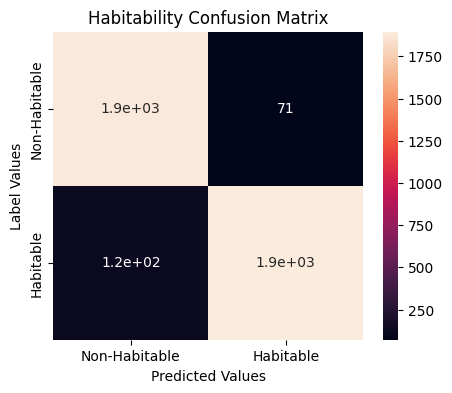

Random Forest Classififier - Classification Report:

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1959
         1.0       0.96      0.94      0.95      2020

    accuracy                           0.95      3979
   macro avg       0.95      0.95      0.95      3979
weighted avg       0.95      0.95      0.95      3979



In [ ]:
# Train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators = 10,
                                                  criterion = 'entropy',
                                                  max_depth = 6,
                                                  max_features = 'log2',
                                                  max_leaf_nodes = 11,
                                                  random_state = 0)
random_forest_classifier.fit(features_train, labels_train)

# Predict the samples in the test subset
random_forest_classifier_predictions = random_forest_classifier.predict(features_test)

# Plot the confusion matrix and print out the classification evaluation report
random_forest_classifier_accuracy = accuracy_score(labels_test, random_forest_classifier_predictions)
random_forest_classifier_confusion_matrix = plot_confusion_matrix(labels_test, random_forest_classifier_predictions)
print(f"Random Forest Classififier - Classification Report:\n")
print(classification_report(labels_test, random_forest_classifier_predictions))

,Feature Importance
st_rad: Stellar Radius [Solar Radius],0.285606
st_logg: Stellar Surface Gravity [log10(cm/s^2)],0.151036
st_teff: Stellar Effective Temperature [K],0.144875
pl_rade: Planet Radius [Earth Radius],0.107683
pl_orbsmax: Planet Orbit Semi-Major Axis [au],0.099043
st_mass: Stellar Mass [Solar mass],0.065238
pl_orbeccen: Planet Orbit Eccentricity,0.046939
dec: Declination of the Planetary System [decimal],0.035281
pl_bmasse: Planet Mass or Mass*sin(i) [Earth Mass],0.025227
st_met: Stellar Metallicity [dex],0.011794


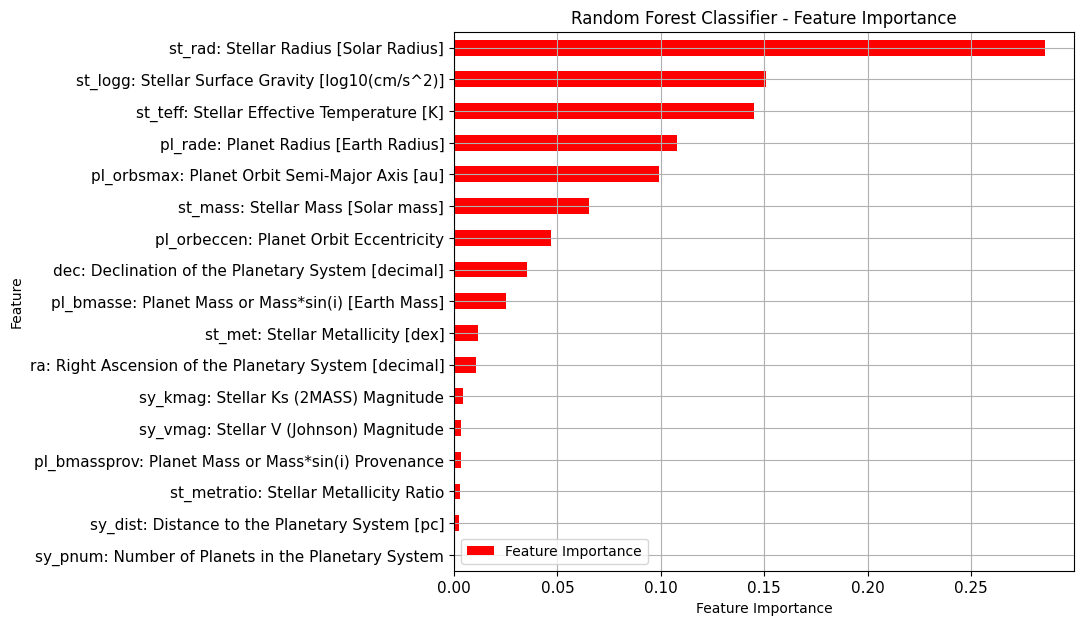

In [ ]:
# Calculate and plot feature importance
feature_importances = pd.DataFrame(data=random_forest_classifier.feature_importances_,
                                   index=feature_columns,
                                   columns=["Feature Importance"])
cmap = cm.get_cmap('hsv')

feature_importances.sort_values(by='Feature Importance', ascending=True, inplace=True)
feature_importances.plot(kind='barh',
                         figsize=(8,7),
                         title='Random Forest Classifier - Feature Importance',
                         xlabel='Feature Importance',
                         ylabel='Feature',
                         fontsize=11,
                         cmap=cmap,
                         grid=True)

feature_importances.sort_values(by='Feature Importance', ascending=False, inplace=True)
feature_importances

PermutationExplainer explainer: 3980it [03:13, 20.48it/s]


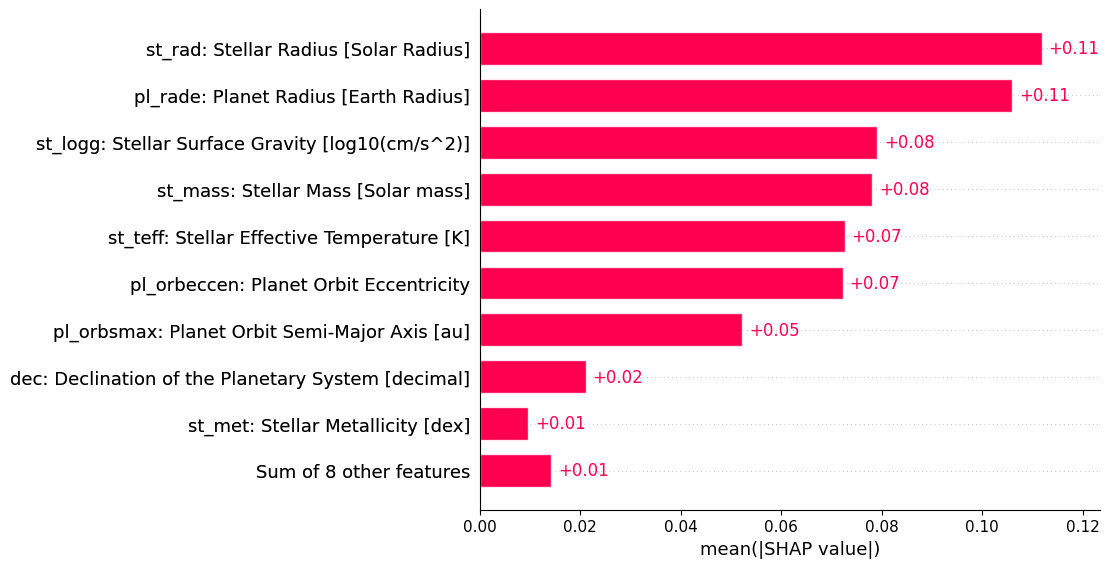

In [ ]:
random_forest_classifier_explainer = shap.Explainer(random_forest_classifier.predict, features_test, feature_names=feature_columns)
random_forest_classifier_shap_values = random_forest_classifier_explainer(features_test)
shap.plots.bar(random_forest_classifier_shap_values)

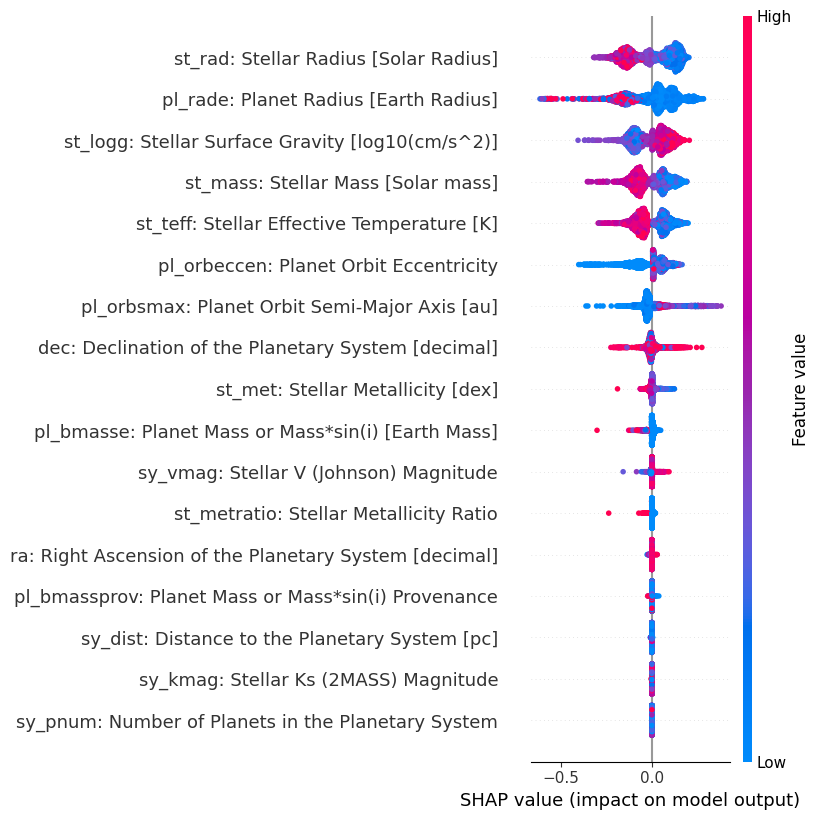

In [ ]:
shap.summary_plot(random_forest_classifier_shap_values, features_test, feature_names=feature_columns)

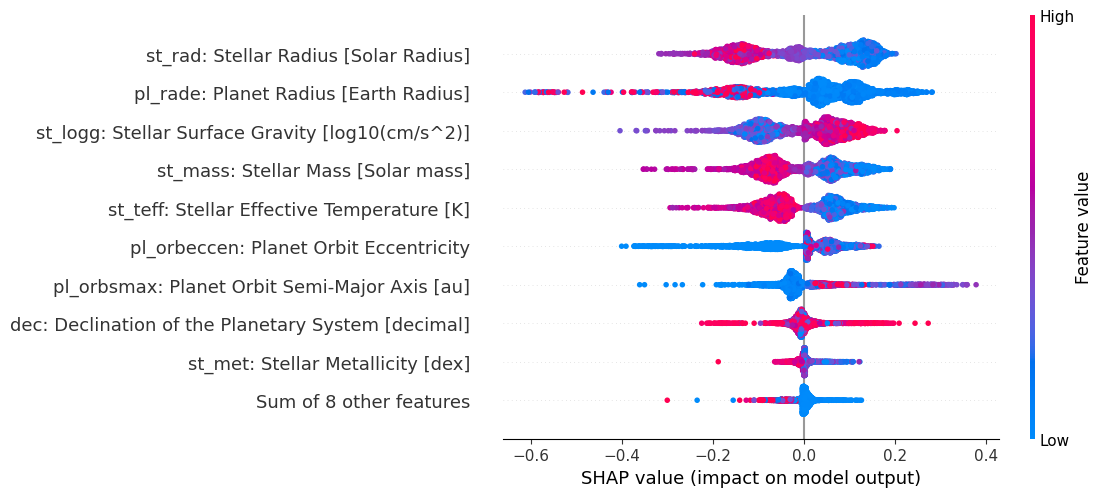

In [ ]:
shap.plots.beeswarm(random_forest_classifier_shap_values)

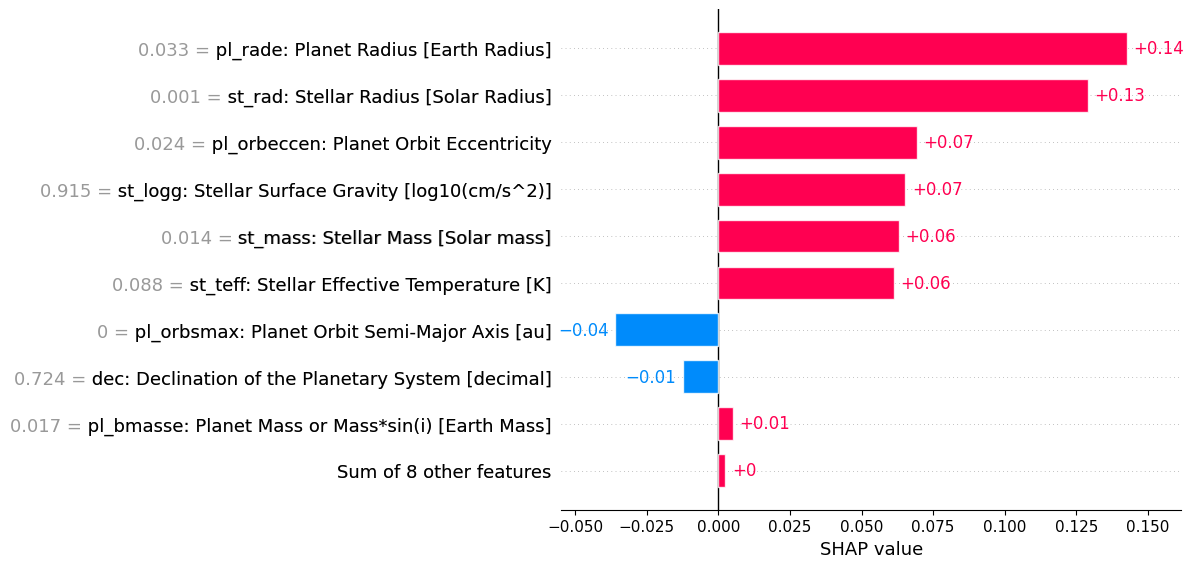

In [ ]:
shap.plots.bar(random_forest_classifier_shap_values[0])

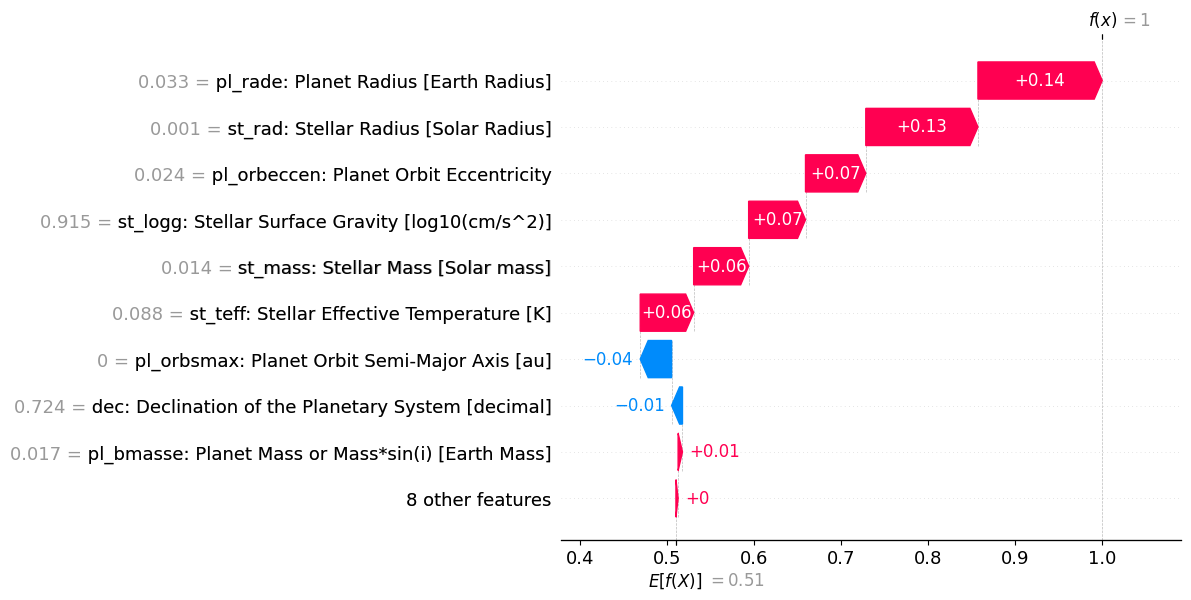

In [ ]:
shap.plots.waterfall(random_forest_classifier_shap_values[0])

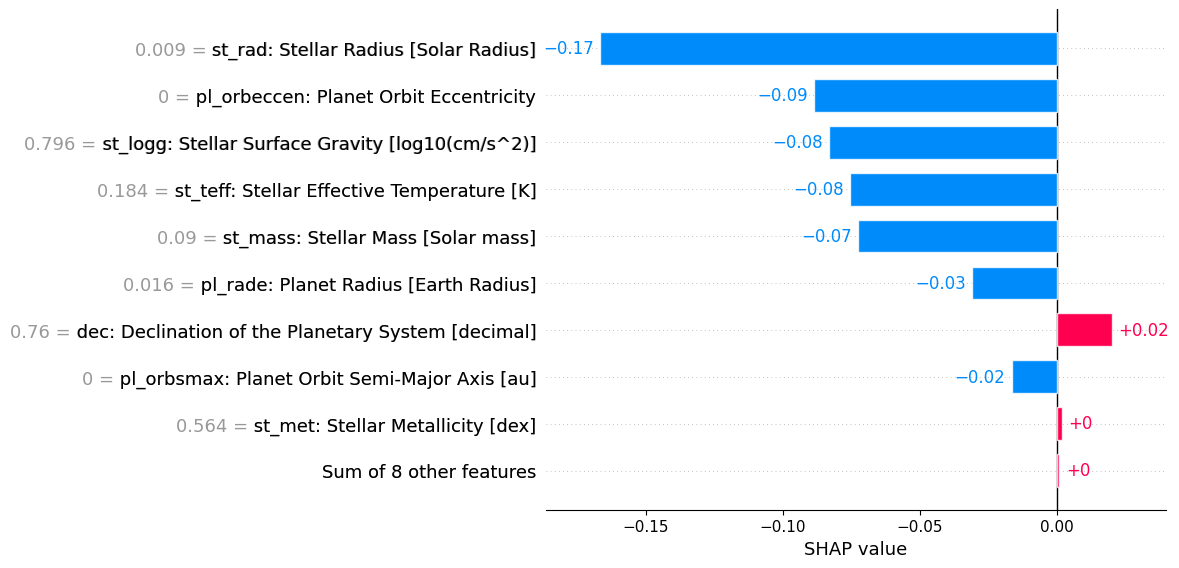

In [ ]:
shap.plots.bar(random_forest_classifier_shap_values[1])

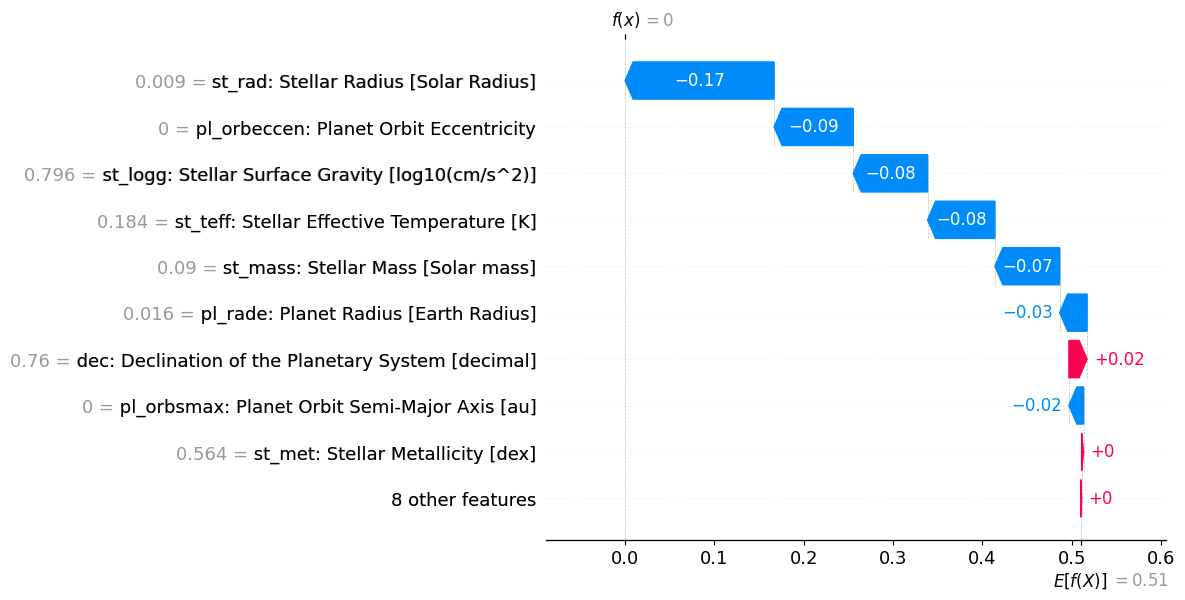

In [ ]:
shap.plots.waterfall(random_forest_classifier_shap_values[1])

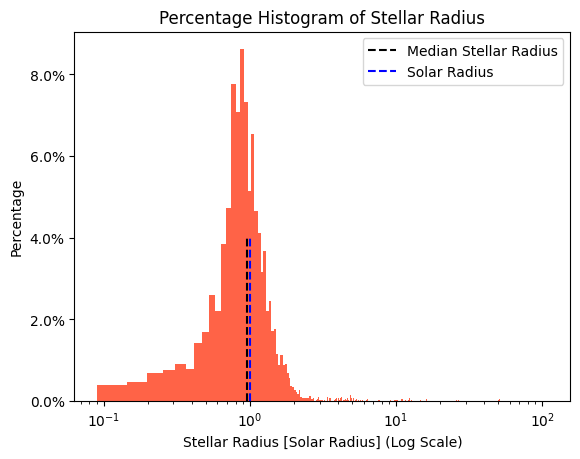

,st_rad
count,4582.000000
mean,1.559398
std,4.352707
min,0.090000
25%,0.780000
50%,0.960000
75%,1.240000
90%,1.690000
95%,2.469500
99%,12.383800


In [ ]:
hist_data = features_to_balance['st_rad']
plt.hist(hist_data,
         bins=2000,
         weights=np.ones(len(hist_data)) / len(hist_data),
         color='tomato')
plt.vlines(x=0.96, ymin=0, ymax=0.04, colors='black', linestyles='dashed', label='Median Stellar Radius')
plt.vlines(x=1, ymin=0, ymax=0.04, colors='blue', linestyles='dashed', label='Solar Radius')
plt.title("Percentage Histogram of Stellar Radius")
plt.xscale('log')
plt.xlabel("Stellar Radius [Solar Radius] (Log Scale)")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()
features_to_balance['st_rad'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])

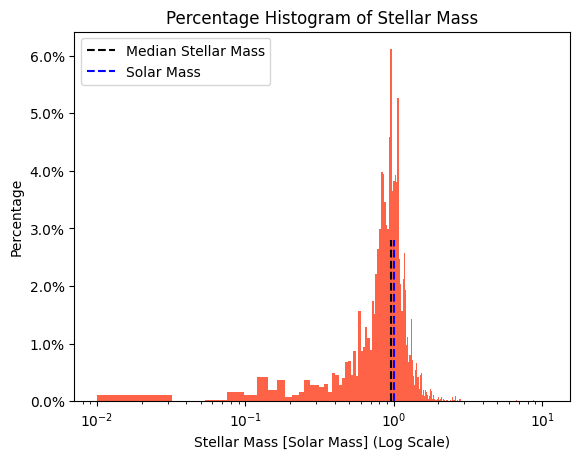

,st_mass
count,4582.000000
mean,0.969596
std,0.415470
min,0.010000
25%,0.810000
50%,0.960000
75%,1.090000
90%,1.280000
95%,1.450000
99%,2.005700


In [ ]:
hist_data = features_to_balance['st_mass']
plt.hist(hist_data,
         bins=500,
         weights=np.ones(len(hist_data)) / len(hist_data),
         color='tomato')
plt.vlines(x=0.96, ymin=0, ymax=0.028, colors='black', linestyles='dashed', label='Median Stellar Mass')
plt.vlines(x=1, ymin=0, ymax=0.028, colors='blue', linestyles='dashed', label='Solar Mass')
plt.title("Percentage Histogram of Stellar Mass")
plt.xscale('log')
plt.xlabel("Stellar Mass [Solar Mass] (Log Scale)")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()
features_to_balance['st_mass'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])

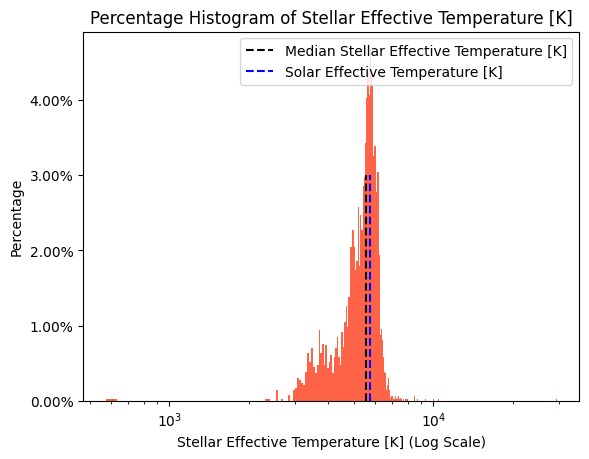

,st_teff
count,4582.000000
mean,5369.282069
std,932.663163
min,575.000000
25%,4955.000000
50%,5560.000000
75%,5900.000000
90%,6161.900000
95%,6313.900000
99%,6829.800000


In [ ]:
hist_data = features_to_balance['st_teff']
plt.hist(hist_data,
         bins=500,
         weights=np.ones(len(hist_data)) / len(hist_data),
         color='tomato')
plt.vlines(x=5560, ymin=0, ymax=0.03, colors='black', linestyles='dashed', label='Median Stellar Effective Temperature [K]')
plt.vlines(x=5772, ymin=0, ymax=0.03, colors='blue', linestyles='dashed', label='Solar Effective Temperature [K]')
plt.title("Percentage Histogram of Stellar Effective Temperature [K]")
plt.xscale('log')
plt.xlabel("Stellar Effective Temperature [K] (Log Scale)")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()
features_to_balance['st_teff'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])

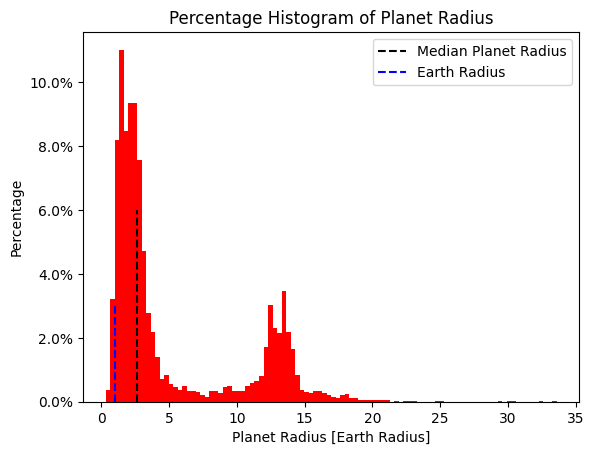

,pl_rade
count,4582.000000
mean,5.240485
std,5.049557
min,0.310000
25%,1.730000
50%,2.650000
75%,9.332750
90%,13.450900
95%,14.199950
99%,18.149280


In [ ]:
hist_data = features_to_balance['pl_rade']
plt.hist(hist_data,
         bins=100,
         weights=np.ones(len(hist_data)) / len(hist_data),
         color='red')
plt.vlines(x=2.65, ymin=0, ymax=0.06, colors='black', linestyles='dashed', label='Median Planet Radius')
plt.vlines(x=1, ymin=0, ymax=0.03, colors='blue', linestyles='dashed', label='Earth Radius')
plt.title("Percentage Histogram of Planet Radius")
plt.xlabel("Planet Radius [Earth Radius]")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()
features_to_balance['pl_rade'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])

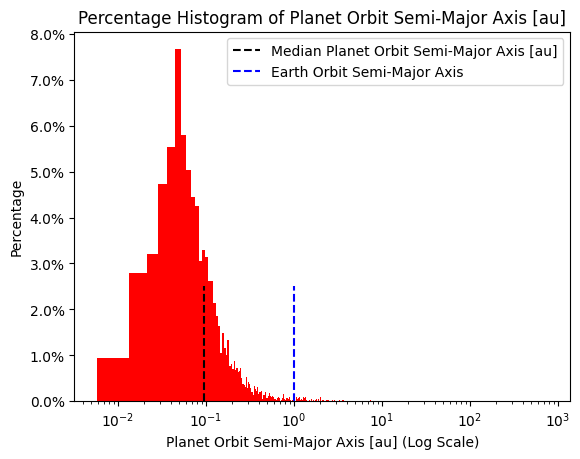

,pl_orbsmax
count,4577.000000
mean,2.231093
std,26.842898
min,0.005800
25%,0.052300
50%,0.096500
75%,0.226220
90%,1.168200
95%,2.732000
99%,16.984000


In [ ]:
features_for_hist = features_to_balance.loc[(features_to_balance['pl_orbsmax'] <= 1150)]
hist_data = features_for_hist['pl_orbsmax']
plt.hist(hist_data,
         bins=100000,
         weights=np.ones(len(hist_data)) / len(hist_data),
         color='red')
plt.vlines(x=0.096650, ymin=0, ymax=0.025, colors='black', linestyles='dashed', label='Median Planet Orbit Semi-Major Axis [au]')
plt.vlines(x=1, ymin=0, ymax=0.025, colors='blue', linestyles='dashed', label='Earth Orbit Semi-Major Axis')
plt.title("Percentage Histogram of Planet Orbit Semi-Major Axis [au]")
plt.xscale('log')
plt.xlabel("Planet Orbit Semi-Major Axis [au] (Log Scale)")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()
features_for_hist['pl_orbsmax'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])

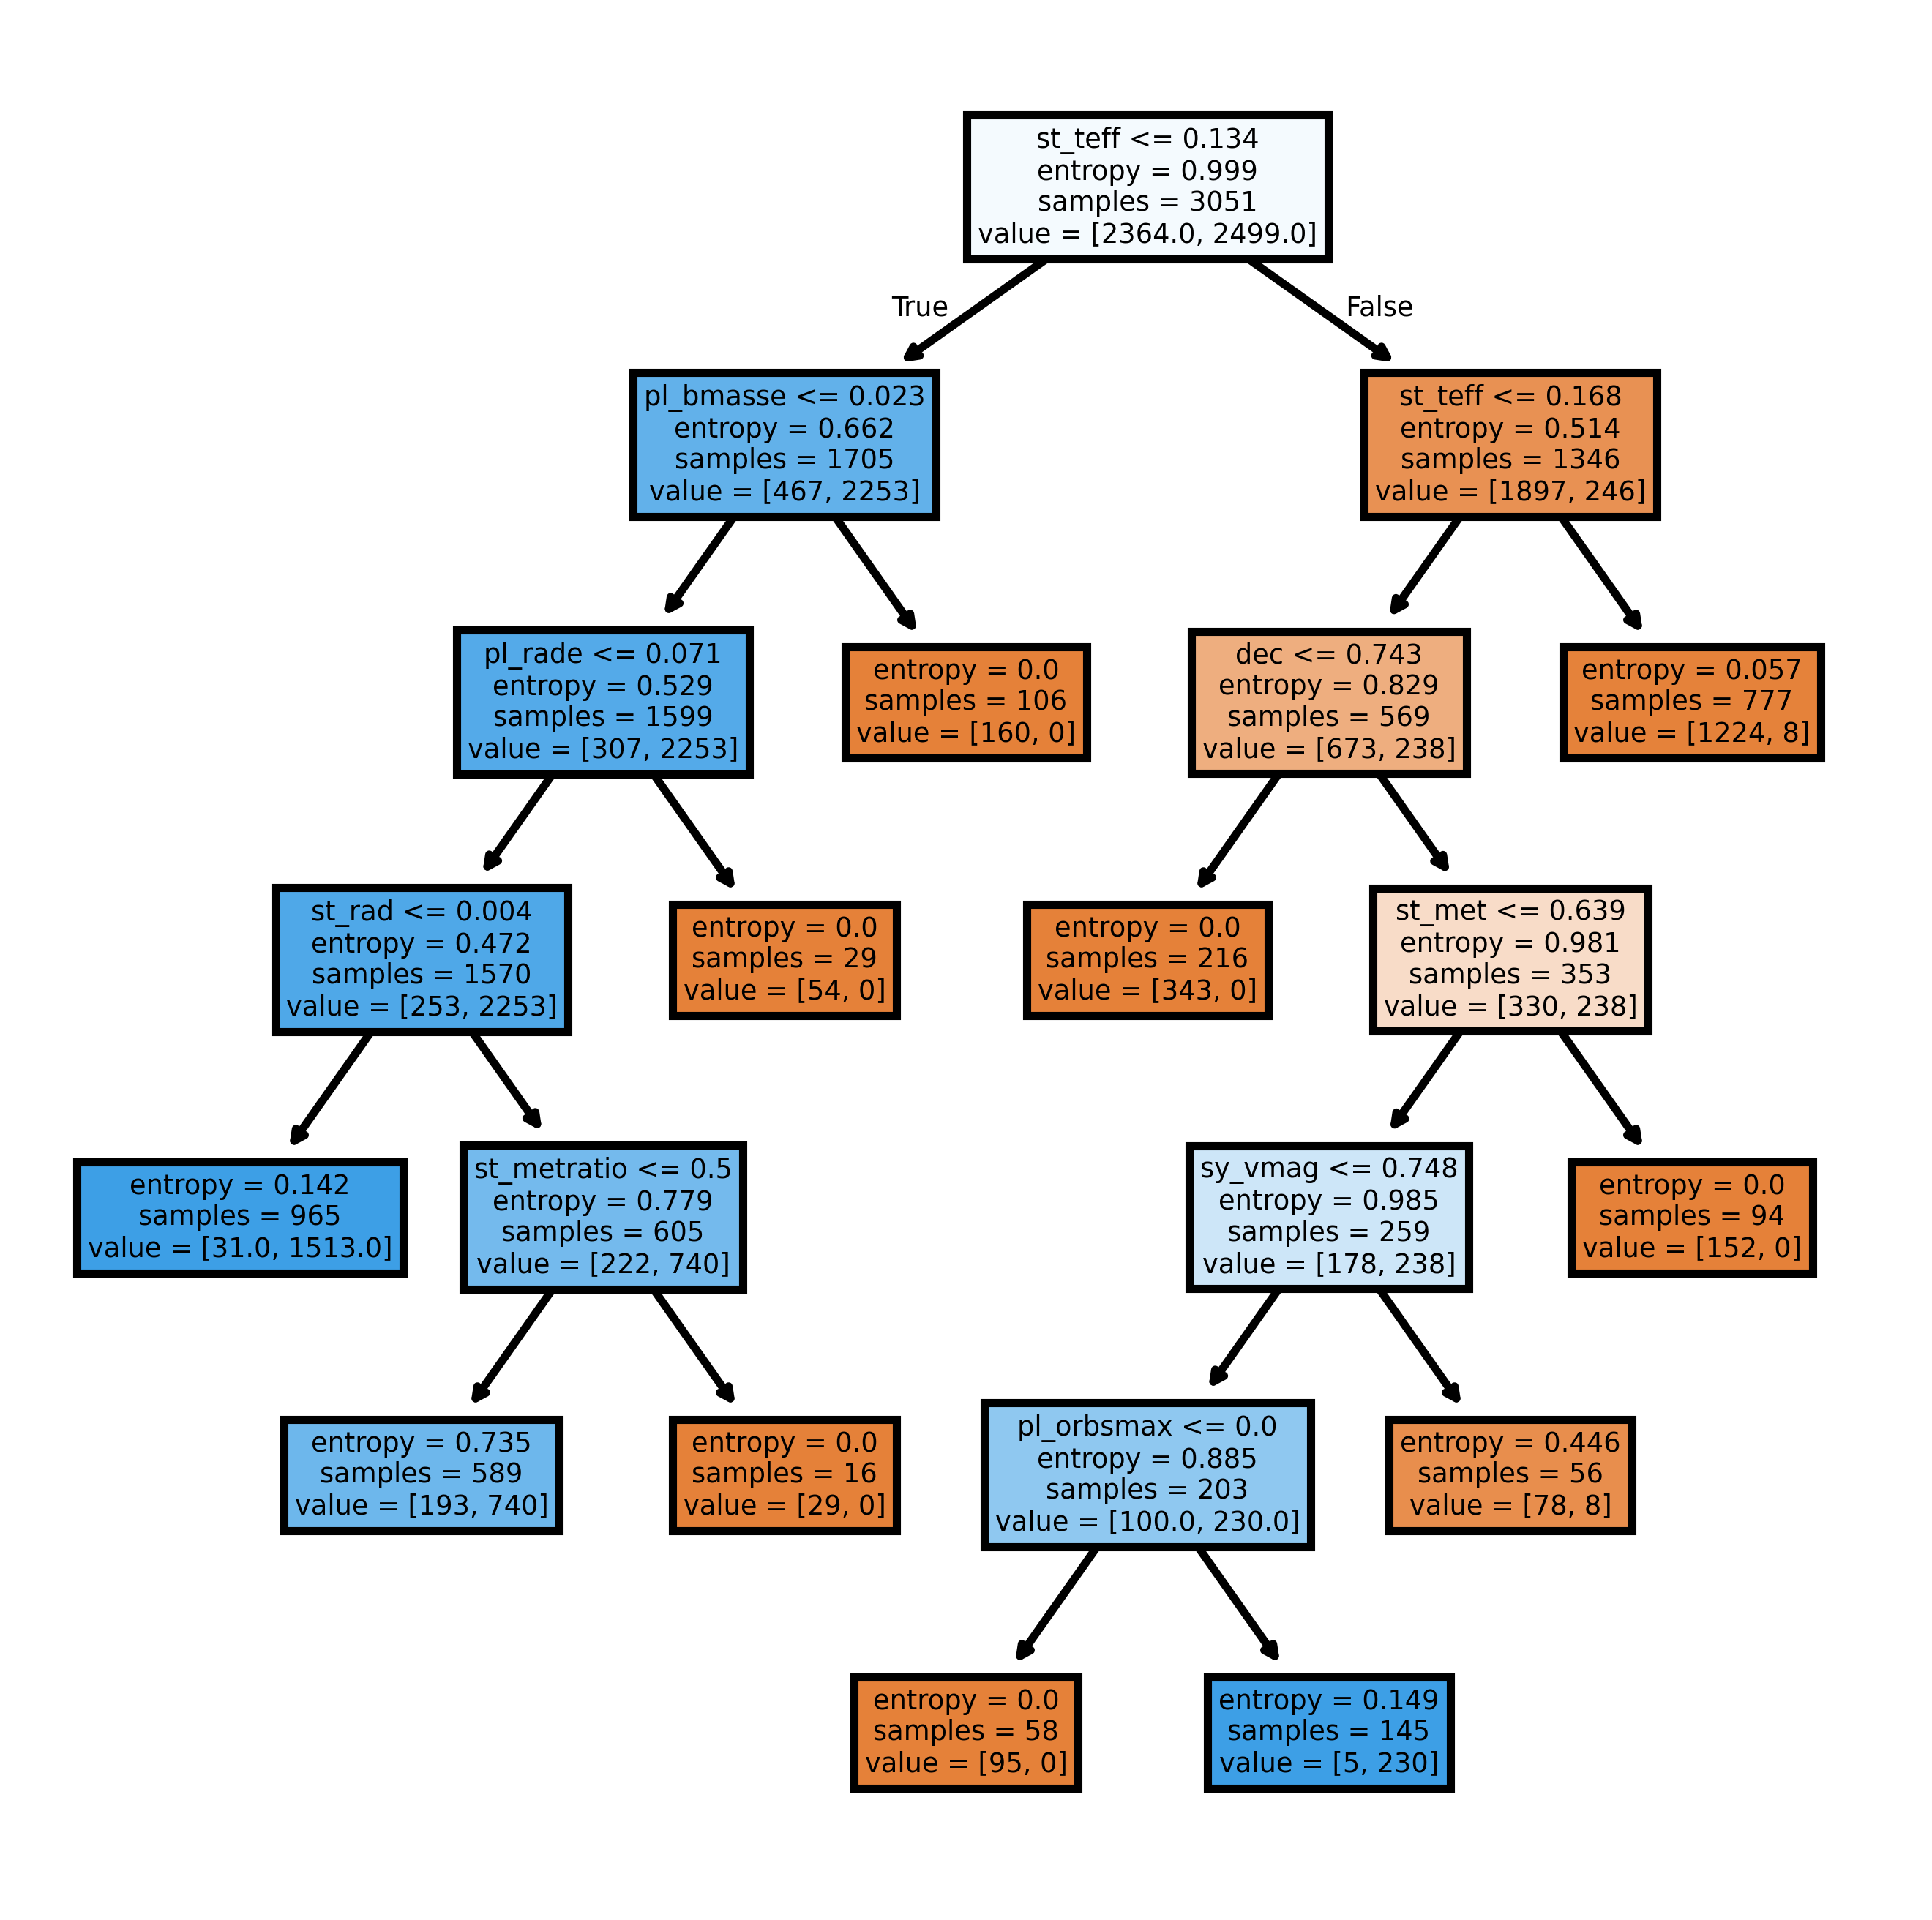

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi=800)
tree.plot_tree(random_forest_classifier.estimators_[3],
               feature_names=features.columns,
               filled=True);
fig.savefig('/content/drive/My Drive/Colab Notebooks/research/CSRSEF/random_forest_individual_tree.png')

In [ ]:
st_mass_vs_pl_orbit_plot_data['st_mass'].describe(percentiles=[.25, .5, .75, .90, .95, .99, .995, .999])

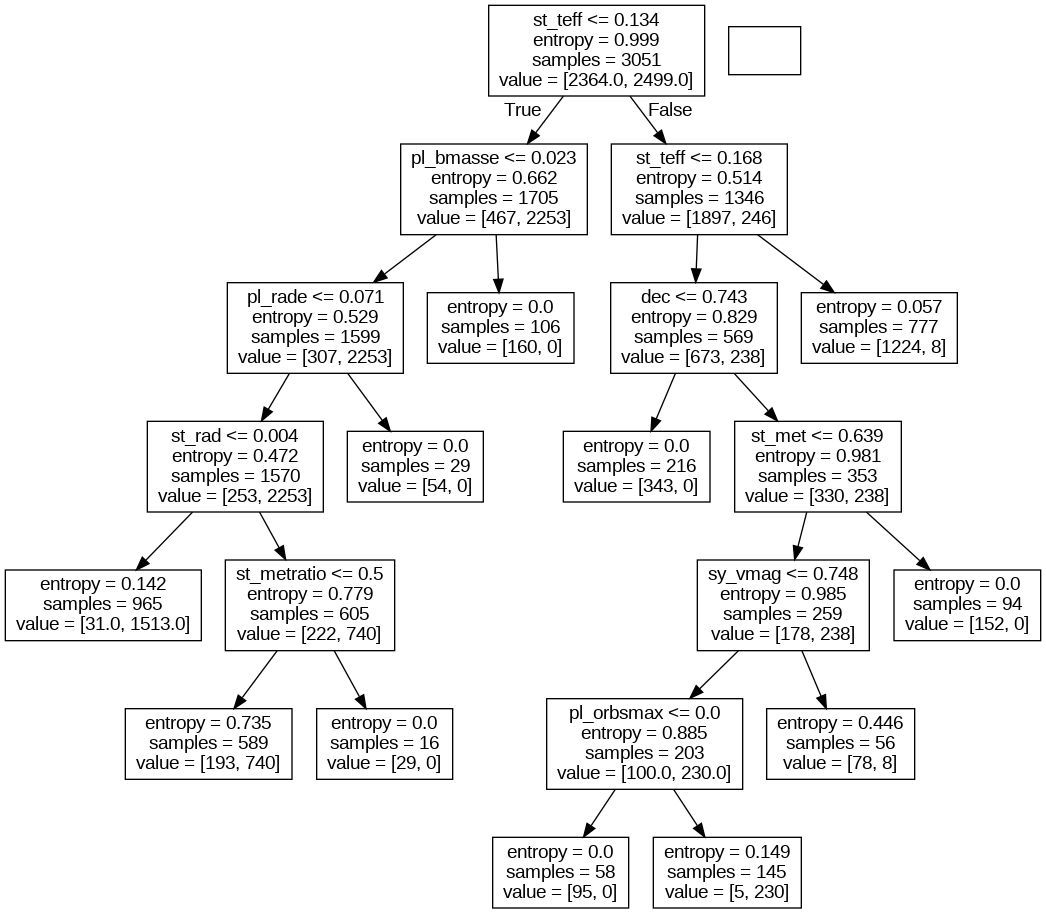

In [ ]:
dot_data = StringIO()
export_graphviz(random_forest_classifier.estimators_[3],
                feature_names=features.columns,
                out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
# Save the Random Forest classifier model
random_forest_pickle = open('/content/drive/My Drive/Colab Notebooks/research/CSRSEF/random_forest_classifier', 'wb')
pickle.dump(random_forest_classifier, random_forest_pickle)
random_forest_pickle.close()

In [ ]:
# Load the Random Forest classifier model and test with test data
loaded_random_forest_classifier = pickle.load(open('/content/drive/My Drive/Colab Notebooks/research/CSRSEF/random_forest_classifier', 'rb'))
pred_results = loaded_random_forest_classifier.predict(features_test)
pred_results

array([1., 0., 1., ..., 1., 0., 0.])

In [ ]:
def search_optimal_params_xgboost(features,
                                  labels,
                                  cross_validation_rounds,
                                  split_test_size,
                                  split_stratify,
                                  split_random_state):
    print(f"Searching the optimal hyper parameters for XGBoost classifier...\n");
    minMaxScaler = MinMaxScaler()

    best_accuracy = 0
    best_n_estimators = 1
    best_max_depth = 1
    best_learning_rate = 1
    best_objective = 'binary:logistic'
    best_eval_metric = 'logloss'
    best_max_leaves = 1

    for n_estimators in range(1, 15, 1):
        for max_depth in range(1, 12, 1):
            for learning_rate in range(1, 10, 1):
                for objective in ['binary:logistic', 'binary:hinge']:
                    for eval_metric in ['logloss', 'rmse', 'error', 'auc']:
                        for max_leaves in range(1, 12, 1):
                            accuracy_sum = 0
                            for round in range(cross_validation_rounds):
                                features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                                            labels,
                                                                                                            test_size=split_test_size,
                                                                                                            stratify=split_stratify,
                                                                                                            random_state=split_random_state,
                                                                                                            shuffle=True)
                                features_train = minMaxScaler.fit_transform(features_train)
                                features_test = minMaxScaler.fit_transform(features_test)
                                xgb_classifier = XGBClassifier(n_estimators=n_estimators,
                                                               max_depth=max_depth,
                                                               learning_rate=learning_rate,
                                                               objective=objective,
                                                               eval_metric=eval_metric,
                                                               max_leaves=max_leaves)
                                xgb_classifier.fit(features_train, labels_train)

                                # Predict the samples in the test subset
                                xgb_classifier_predictions = xgb_classifier.predict(features_test)

                                # Plot the confusion matrix and print out the classification evaluation report
                                xgb_classifier_accuracy = accuracy_score(labels_test, xgb_classifier_predictions)
                                accuracy_sum += xgb_classifier_accuracy
                            avg_accuracy = accuracy_sum / cross_validation_rounds
                            if avg_accuracy > best_accuracy:
                                best_accuracy = avg_accuracy
                                best_n_estimators = n_estimators
                                best_max_depth = max_depth
                                best_learning_rate = learning_rate
                                best_objective = objective
                                best_eval_metric = eval_metric
                                best_max_leaves = max_leaves
                                print(f"Found a better avg accuracy at: {best_accuracy} - n_estimators: {best_n_estimators}, max_depth: {best_max_depth}, learning_rate: {best_learning_rate}, objective: {best_objective}, eval_metric: {best_eval_metric}, max_leaves: {best_max_leaves}")

search_optimal_params_xgboost(features=features,
                              labels=labels,
                              cross_validation_rounds=3,
                              split_test_size=0.45,
                              split_stratify=labels,
                              split_random_state=42)

Searching the optimal hyper parameters for XGBoost classifier...

Found a better avg accuracy at: 0.5076652425232471 - n_estimators: 1, max_depth: 1, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 1
Found a better avg accuracy at: 0.8278461925106809 - n_estimators: 1, max_depth: 1, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 2
Found a better avg accuracy at: 0.8743402865041467 - n_estimators: 1, max_depth: 2, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 3
Found a better avg accuracy at: 0.8786127167630058 - n_estimators: 1, max_depth: 3, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 6
Found a better avg accuracy at: 0.8951997989444584 - n_estimators: 1, max_depth: 4, learning_rate: 1, objective: binary:logistic, eval_metric: logloss, max_leaves: 9
Found a better avg accuracy at: 0.9364161849710982 - n_estimators: 1, max_depth: 5, learning_rate: 1, ob

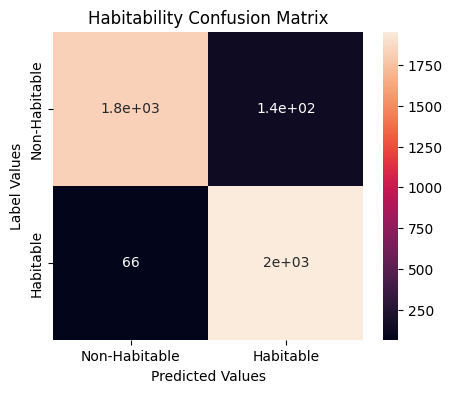

XGBoost Classififier - Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      1959
         1.0       0.94      0.97      0.95      2020

    accuracy                           0.95      3979
   macro avg       0.95      0.95      0.95      3979
weighted avg       0.95      0.95      0.95      3979



In [ ]:
# Train a XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=4,
                               max_depth=3,
                               learning_rate=1,
                               objective='binary:hinge',
                               eval_metric='logloss',
                               max_leaves=6)
xgb_classifier.fit(features_train, labels_train)

# Predict the samples in the test subset
xgb_classifier_predictions = xgb_classifier.predict(features_test)

# Plot the confusion matrix and print out the classification evaluation report
xgb_classifier_accuracy = accuracy_score(labels_test, xgb_classifier_predictions)
xgb_classifier_confusion_matrix = plot_confusion_matrix(labels_test, xgb_classifier_predictions)
print(f"XGBoost Classififier - Classification Report:\n")
print(classification_report(labels_test, xgb_classifier_predictions))

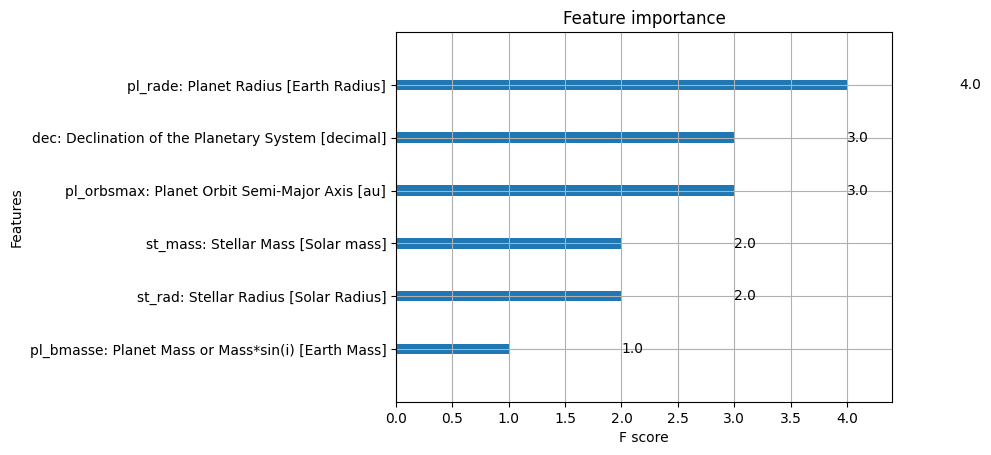

In [ ]:
# Plot XGBoost classifier feature importance
xgb_classifier.get_booster().feature_names = feature_columns
plot_importance(xgb_classifier)
plt.show()

PermutationExplainer explainer: 3980it [02:38, 23.73it/s]                          


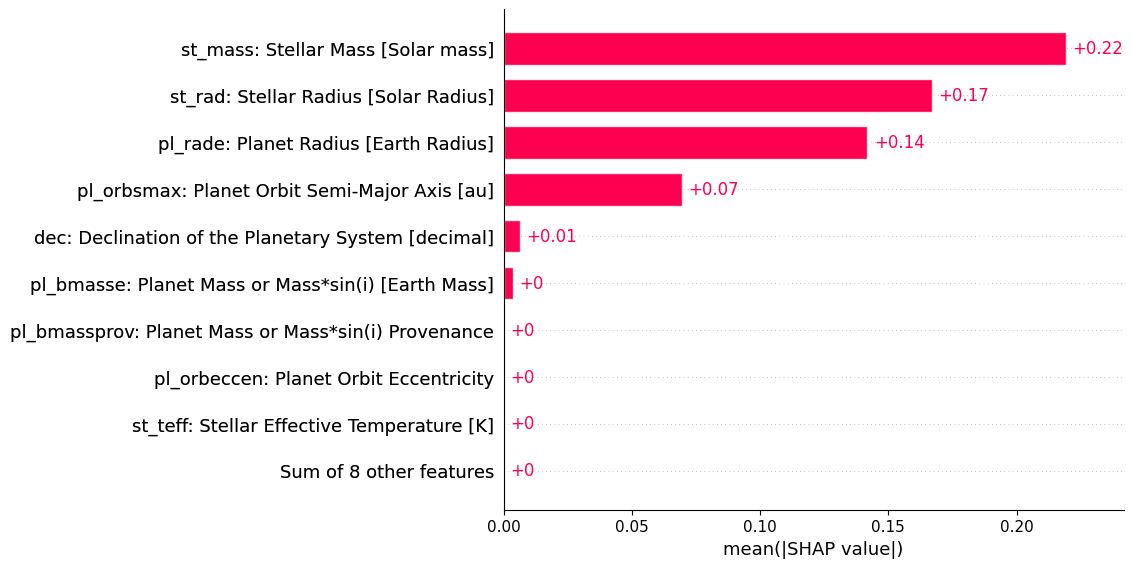

In [ ]:
xgb_classifier_explainer = shap.Explainer(xgb_classifier.predict, features_test, feature_names=feature_columns)
xgb_classifier_shap_values = xgb_classifier_explainer(features_test)
shap.plots.bar(xgb_classifier_shap_values)

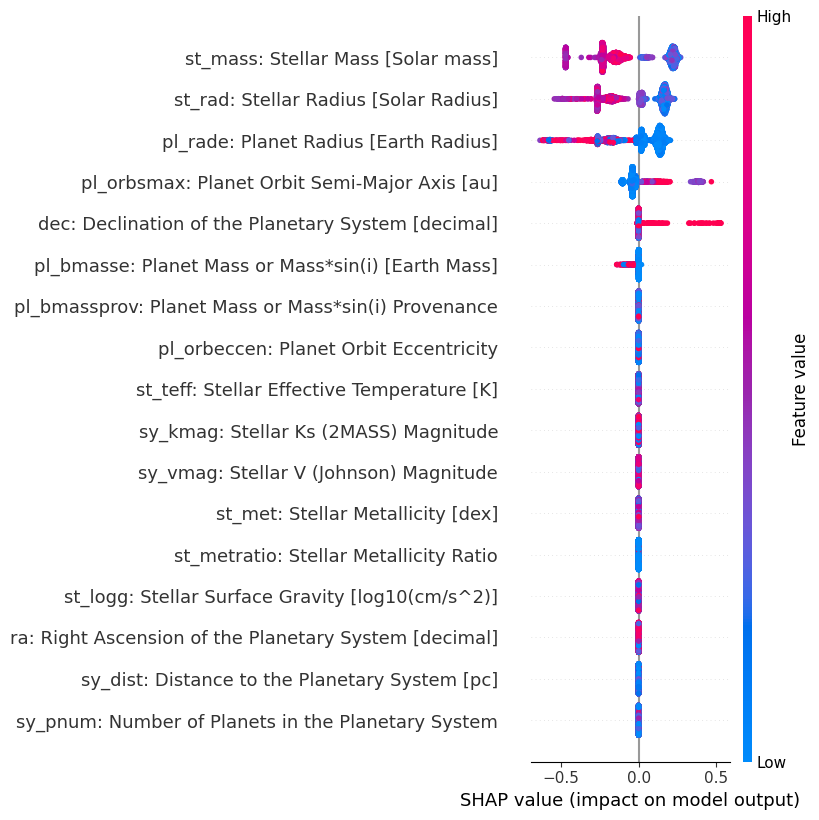

In [ ]:
shap.summary_plot(xgb_classifier_shap_values, features_test, feature_names=feature_columns)

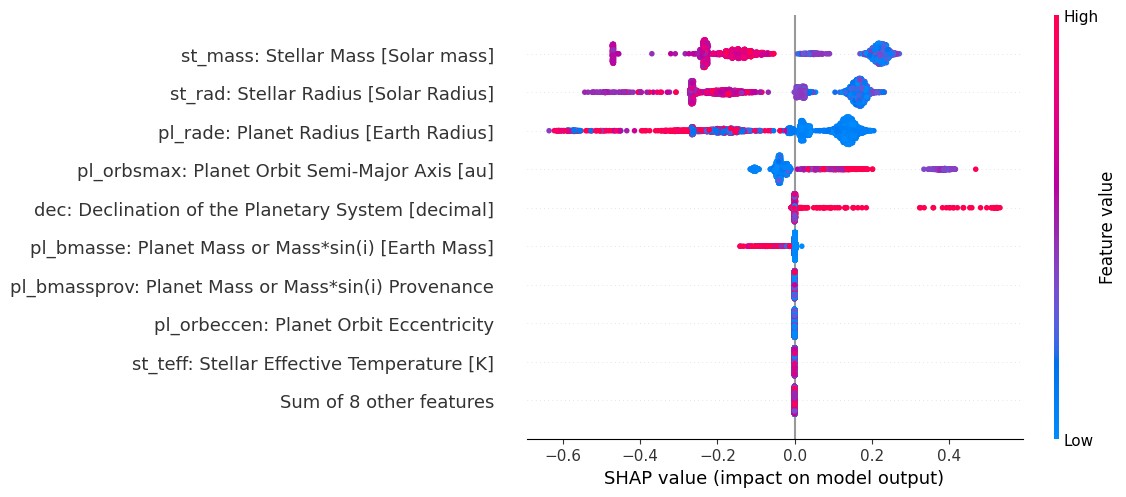

In [ ]:
shap.plots.beeswarm(xgb_classifier_shap_values)

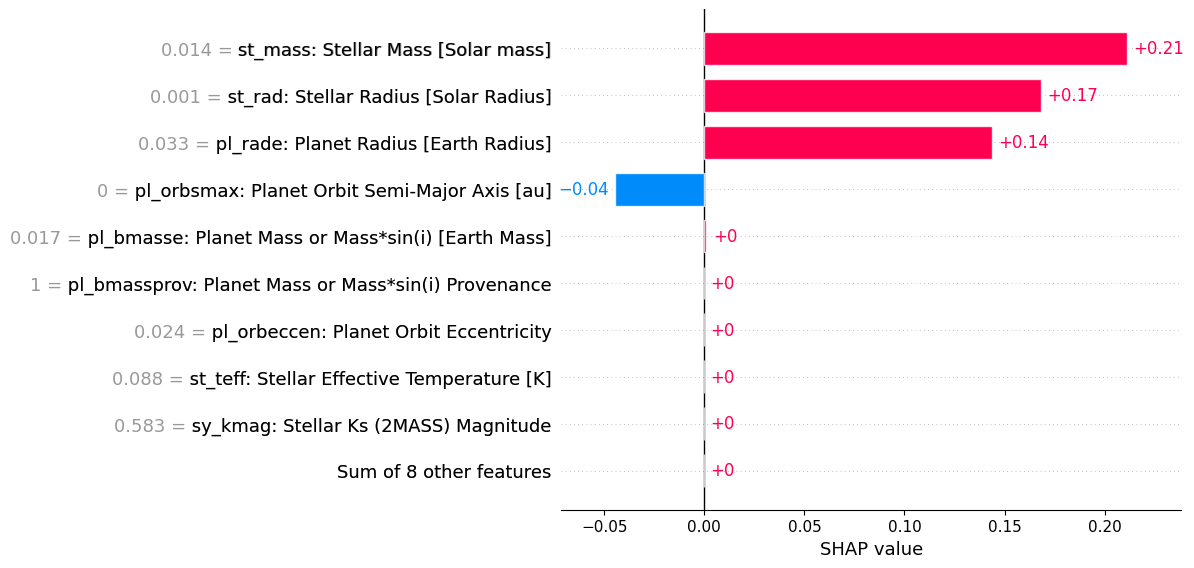

In [ ]:
shap.plots.bar(xgb_classifier_shap_values[0])

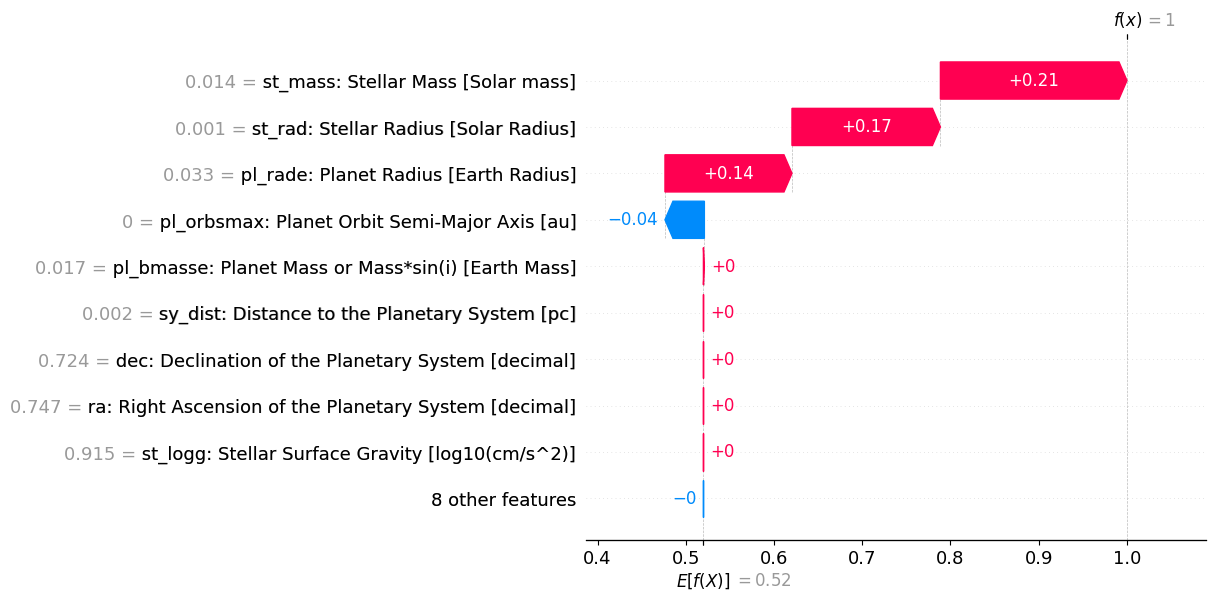

In [ ]:
shap.plots.waterfall(xgb_classifier_shap_values[0])

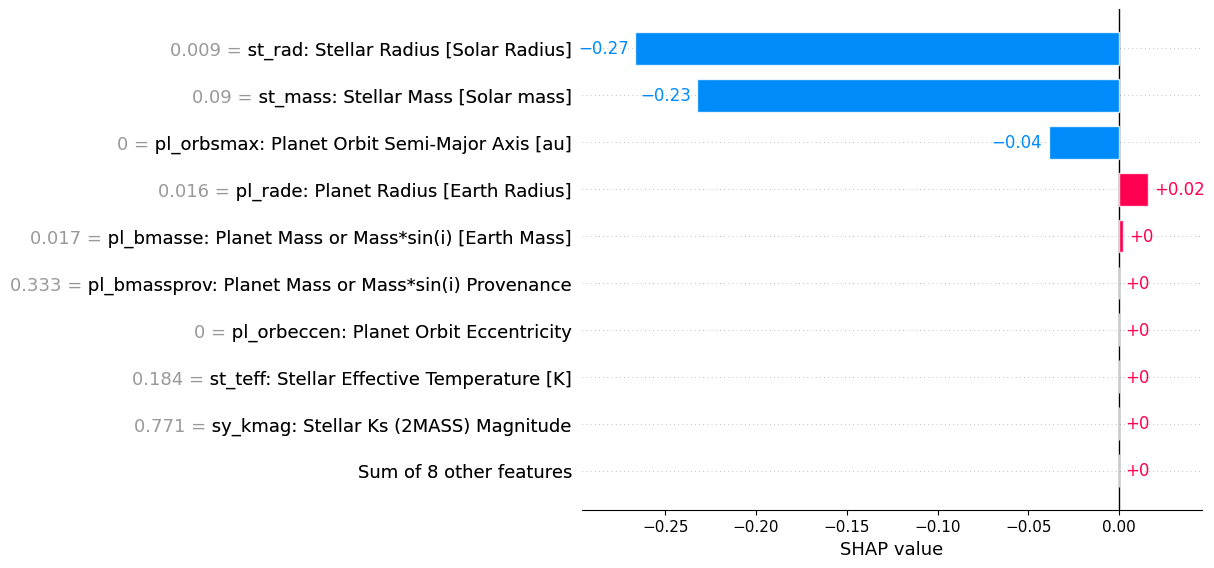

In [ ]:
shap.plots.bar(xgb_classifier_shap_values[1])

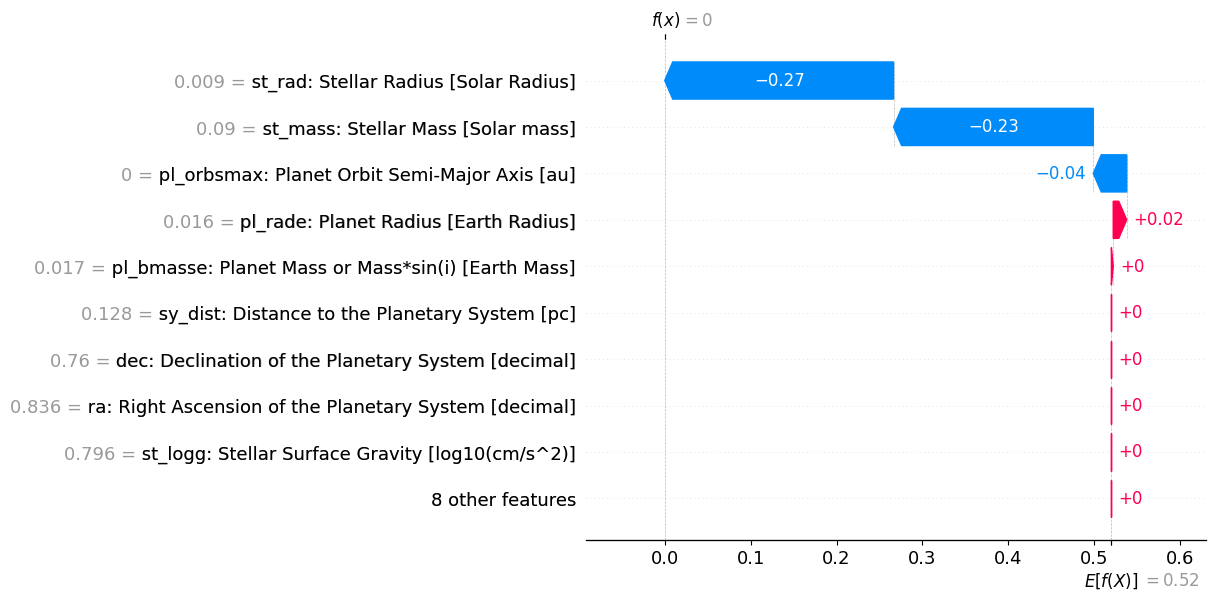

In [ ]:
shap.plots.waterfall(xgb_classifier_shap_values[1])

In [ ]:
# Save the XGBoost classifier model
xgboost_pickle = open('/content/drive/My Drive/Colab Notebooks/research/CSRSEF/xgboost_classifier', 'wb')
pickle.dump(xgb_classifier, xgboost_pickle)
xgboost_pickle.close()

In [ ]:
# Load the XGBoost classifier model and test with test data
loaded_xgboost_classifier = pickle.load(open('/content/drive/My Drive/Colab Notebooks/research/CSRSEF/xgboost_classifier', 'rb'))
pred_results = loaded_xgboost_classifier.predict(features_test)
pred_results

array([0, 1, 0, ..., 1, 0, 1])